In [24]:
# Cell 0: Install extras (run once)
!pip install -q numpy pandas scikit-learn matplotlib plotly ipywidgets pymc3 arviz
# Enable widgets in Colab:
from google.colab import output
output.enable_custom_widget_manager()


In [25]:
# Cell 1
import numpy as np, pandas as pd
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame
df.head()
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [26]:
# Cell 2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['MedHouseVal']).values
y = df['MedHouseVal'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [27]:
# Cell 3
# Add bias column
Xb = np.hstack([np.ones((X_train_s.shape[0],1)), X_train_s])
Xt = X_test_s
Xt_b = np.hstack([np.ones((Xt.shape[0],1)), Xt])

# Normal equation
theta_closed = np.linalg.pinv(Xb.T @ Xb) @ Xb.T @ y_train

# Predictions
y_pred_closed = Xt_b @ theta_closed

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
print("Closed-form MSE:", mean_squared_error(y_test, y_pred_closed))
print("Closed-form R2:", r2_score(y_test, y_pred_closed))


Closed-form MSE: 0.5558915986952424
Closed-form R2: 0.5757877060324523


## The Normal Equation (Matrix Math)

The normal equation is a closed-form solution for the weights ($\theta$) of a linear regression model. It directly calculates the optimal $\theta$ that minimizes the cost function (Mean Squared Error) without requiring an iterative optimization process like Gradient Descent.

The formula for the normal equation is:

$\theta = (X^T X)^{-1} X^T y$

Let's break down the components:

*   **$y$**: This is a vector of the target variable values. In our case, it's the `MedHouseVal`.
*   **$X$**: This is the design matrix. Each row represents a data instance, and each column represents a feature. It's important to include a column of ones in $X$ to account for the intercept term (bias). In the code, we created `Xb` by horizontally stacking a column of ones with the scaled feature matrix `X_train_s`.
*   **$X^T$**: This is the transpose of the design matrix $X$.
*   **$(X^T X)^{-1}$**: This is the inverse of the matrix product of $X^T$ and $X$. This part of the equation is crucial and can only be calculated if $X^T X$ is invertible (i.e., it's a square matrix with a non-zero determinant). If it's not invertible, we might encounter issues, and techniques like using the pseudo-inverse (as done in the code with `np.linalg.pinv`) can be used.
*   **$X^T y$**: This is the matrix product of the transpose of the design matrix and the target vector.

**How it works (Intuitively):**

The normal equation essentially finds the value of $\theta$ that makes the vector of residuals (the difference between the actual $y$ values and the predicted $\hat{y}$ values) orthogonal to the column space of $X$. In simpler terms, it finds the $\theta$ that minimizes the "distance" between the actual $y$ and the values predicted by the linear model.

**Advantages:**

*   **No learning rate to tune:** Unlike Gradient Descent, you don't need to worry about setting and tuning a learning rate.
*   **Guaranteed to find the global optimum:** For linear regression, the cost function is convex, so the normal equation will always find the global minimum.

**Disadvantages:**

*   **Computationally expensive for large datasets:** Calculating the inverse of $X^T X$ can be computationally expensive, especially when the number of features is very large. The complexity is roughly $O(n^3)$, where $n$ is the number of features.
*   **Can be slow if $X^T X$ is not invertible:** If the design matrix has linearly dependent columns (multicollinearity), $X^T X$ will be singular, and its inverse won't exist. Using the pseudo-inverse can help in such cases, but it adds complexity.

In the code, `np.linalg.pinv(Xb.T @ Xb) @ Xb.T @ y_train` directly implements this formula to calculate the optimal `theta_closed`.

In [28]:
# Cell 4: gradient descent
def gradient_descent(X, y, lr=0.01, n_iter=5000):
    m, n = X.shape
    theta = np.zeros(n)
    for i in range(n_iter):
        grad = (2/m) * X.T @ (X @ theta - y)
        theta -= lr * grad
    return theta

Xb_all = np.hstack([np.ones((X_train_s.shape[0],1)), X_train_s])
theta_gd = gradient_descent(Xb_all, y_train, lr=0.01, n_iter=5000)

# test preds
Xt_b = np.hstack([np.ones((X_test_s.shape[0],1)), X_test_s])
y_pred_gd = Xt_b @ theta_gd
print("GD MSE:", mean_squared_error(y_test, y_pred_gd), "R2:", r2_score(y_test, y_pred_gd))


GD MSE: 0.5559990732458019 R2: 0.575705689995975


## Gradient Descent Concepts: Learning Rate, Iterations, and Convergence

Gradient Descent is an iterative optimization algorithm used to find the minimum of a function, in this case, the cost function of our linear regression model. It works by repeatedly adjusting the model's parameters (the weights, $\theta$) in the direction of the steepest decrease of the cost function. Here's a breakdown of the key concepts:

*   **Learning Rate ($\alpha$ or `lr`):**
    *   The learning rate is a hyperparameter that determines the size of the steps taken during each iteration of Gradient Descent.
    *   Think of it as how quickly the algorithm "learns" and moves towards the minimum.
    *   A **large learning rate** can cause the algorithm to overshoot the minimum and potentially diverge (fail to converge).
    *   A **small learning rate** will result in slower convergence, requiring more iterations to reach the minimum, but it's less likely to overshoot.
    *   Choosing an appropriate learning rate is crucial for effective Gradient Descent. It often requires experimentation and tuning.

*   **Iterations (`n_iter`):**
    *   An iteration refers to a single step in the Gradient Descent process.
    *   In each iteration, the algorithm calculates the gradient of the cost function with respect to the current parameters and updates the parameters in the opposite direction of the gradient.
    *   The number of iterations determines how many times this update process is repeated.
    *   A sufficient number of iterations is needed for the algorithm to approach the minimum. If the number of iterations is too small, the algorithm might stop before reaching the optimal solution.

*   **Convergence:**
    *   Convergence occurs when the Gradient Descent algorithm approaches the minimum of the cost function and the parameter updates become very small.
    *   Ideally, the algorithm converges to the global minimum for convex cost functions like the one in linear regression.
    *   We can monitor convergence by observing how the cost function changes over iterations. When the cost function stops decreasing significantly, or the parameter updates are negligible, the algorithm has likely converged.
    *   Convergence can also be determined by setting a tolerance level for the change in the cost function or parameters between iterations.

In the provided code for `gradient_descent`:

*   `lr` represents the learning rate, set to `0.01`.
*   `n_iter` represents the number of iterations, set to `5000`.

The algorithm runs for `n_iter` steps, updating `theta` in each step based on the gradient and the learning rate. The goal is that after `n_iter` iterations, `theta` will be close to the optimal values that minimize the cost function, indicating convergence.

In [29]:
# Cell 5
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred_sklearn = lr.predict(X_test_s)
print("sklearn MSE:", mean_squared_error(y_test, y_pred_sklearn))
print("sklearn R2:", r2_score(y_test, y_pred_sklearn))


sklearn MSE: 0.5558915986952442
sklearn R2: 0.575787706032451


In [30]:
# Cell 6
import plotly.graph_objs as go
idx = np.arange(len(y_test))
fig = go.Figure()
fig.add_trace(go.Scatter(x=idx, y=y_test, mode='markers', name='actual'))
fig.add_trace(go.Scatter(x=idx, y=y_pred_closed, mode='markers', name='pred_closed'))
# Add y=x line for perfect predictions
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode='lines', name='perfect_prediction', line=dict(color='red', dash='dash')))
fig.update_layout(title='Actual vs Predicted (closed form)', xaxis_title='Actual Values', yaxis_title='Predicted Values')
fig.show()

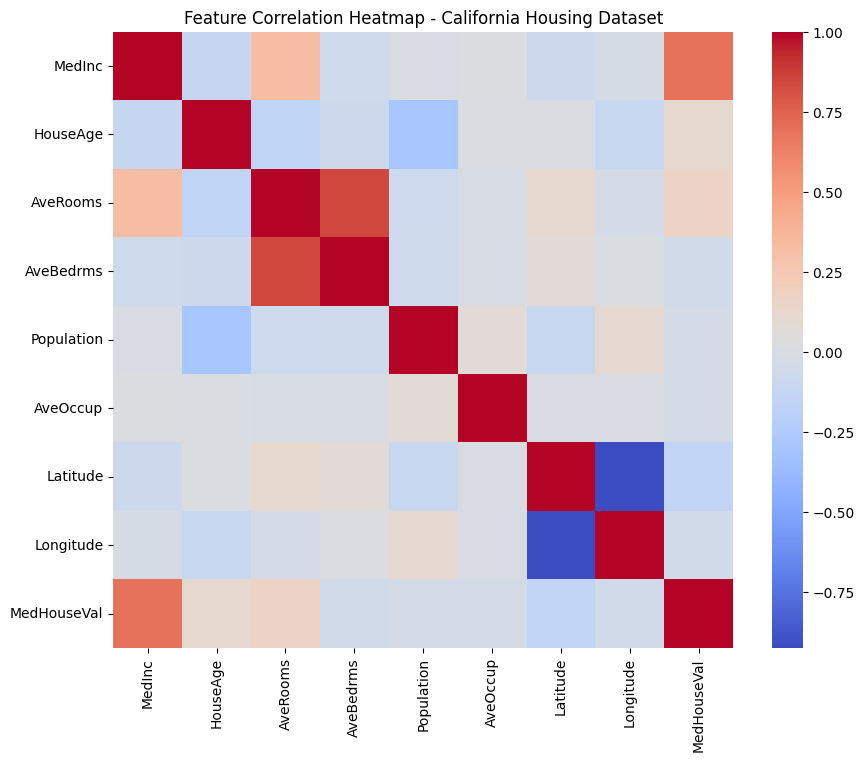

In [31]:
# Correlation Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap - California Housing Dataset")
plt.show()


##  Performance of Linear Regression Models

We implemented three variations of Linear Regression:

1. **Closed Form Solution** (Normal Equation) — Solves directly using matrix operations.
2. **Gradient Descent** — Iterative optimization approach.
3. **Sklearn's LinearRegression** — Standard library implementation.

**Evaluation Metrics:**

| Method            | MSE                 | R² Score          |
|-------------------|---------------------|-------------------|
| Closed Form       | 0.5558915986952424  | 0.5757877060324523 |
| Gradient Descent  | 0.5559990732458019  | 0.575705689995975 |
| Sklearn           | 0.5558915986952442  | 0.575787706032451 |

 All three approaches produce **very similar results**, confirming that our from-scratch implementations are correct.
Small differences may occur due to numerical precision or optimization convergence.

## Visual Comparison: Actual vs Predicted Values

The scatter plot above compares **Actual House Prices** with those predicted by our model.

- **Dots close together** indicate accurate predictions.
- Perfect predictions would fall exactly on the `y = x` line.
- Deviations indicate underestimation or overestimation by the model.

This visualization helps us **quickly spot where the model performs well and where it struggles**.

##  Insights from the California Housing Dataset

The dataset contains various factors influencing housing prices in California.

Key points:
- **Median Income (`MedInc`)** has a **strong positive correlation** with median house value.
- **Average Rooms (`AveRooms`)** also correlates positively.
- Geographical features like **Latitude** and **Longitude** influence prices due to coastal and city proximity.
- Some features have weak or noisy relationships, which may reduce model performance.

Understanding these relationships is crucial for **feature engineering** and **model improvement**.

##  Insights from the California Housing Dataset

The dataset contains various factors influencing housing prices in California.

Key points:
- **Median Income (`MedInc`)** has a **strong positive correlation** with median house value. High correlation with `MedHouseVal` means strong predictive potential.
- **Average Rooms (`AveRooms`)** also correlates positively.
- Geographical features like **Latitude** and **Longitude** influence prices due to coastal and city proximity.
- Some features have weak or noisy relationships, which may reduce model performance.

Understanding these relationships is crucial for **feature engineering** and **model improvement**.

Output()

Bayesian pred mean MSE: 0.6589145825080973
Bayesian pred mean R2: 0.49716875155065865


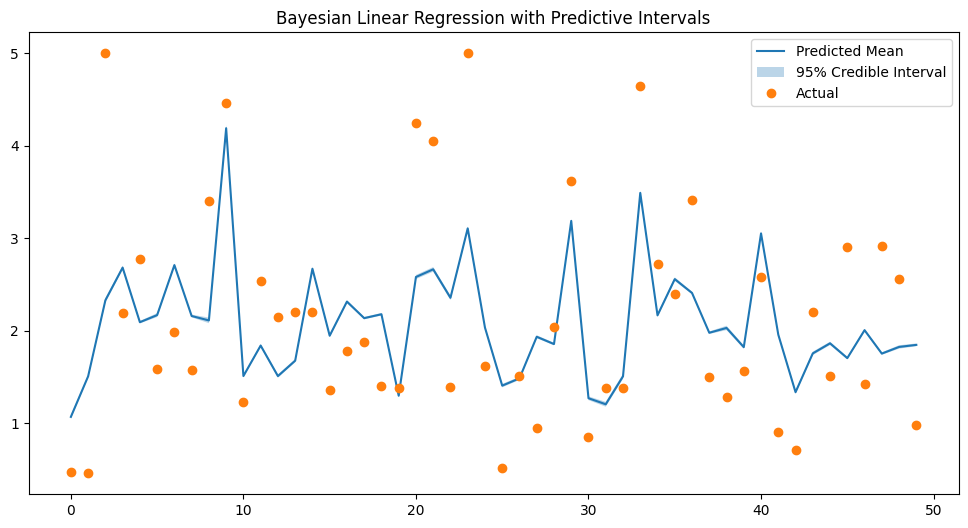

In [32]:
# Install latest PyMC
!pip install pymc arviz --quiet

import pymc as pm
import arviz as az
import numpy as np

# Use only first 3 features for faster sampling
X_small = X_train_s[:, :3]
X_small_test = X_test_s[:, :3]

with pm.Model() as linear_model:
    # Priors for parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X_small.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value
    mu = alpha + pm.math.dot(X_small, betas)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

    # Sampling posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)

#  Extract parameter samples from posterior
alpha_samp = trace.posterior['alpha'].stack(draws=("chain","draw")).values  # (draws,)
betas_samp = trace.posterior['betas'].stack(draws=("chain","draw")).values  # (features, draws)

# Predictions for test set
preds = alpha_samp + X_small_test @ betas_samp   # (n_test, draws)

# Predictive mean & 95% credible intervals
pred_mean = preds.mean(axis=1)  # (n_test,)
pred_lower = np.percentile(preds, 2.5, axis=1)
pred_upper = np.percentile(preds, 97.5, axis=1)

# Metrics
from sklearn.metrics import mean_squared_error, r2_score
print("Bayesian pred mean MSE:", mean_squared_error(y_test, pred_mean))
print("Bayesian pred mean R2:", r2_score(y_test, pred_mean))

# Plot predictions with uncertainty for first 50 samples
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(pred_mean[:50], label='Predicted Mean')
plt.fill_between(np.arange(50), pred_lower[:50], pred_upper[:50], alpha=0.3, label='95% Credible Interval')
plt.plot(y_test[:50], label='Actual', marker='o', linestyle='')
plt.legend()
plt.title('Bayesian Linear Regression with Predictive Intervals')
plt.show()


##  Bayesian Linear Regression: Adding Uncertainty to Predictions

Our earlier Linear Regression models gave **point estimates** — a single predicted value for each house price.

In contrast, **Bayesian Linear Regression** treats the model parameters (**weights and intercept**) as **random variables** with probability distributions.

###  How It Works
1. **Priors** — We define initial beliefs about parameters before seeing the data.
2. **Likelihood** — We model how the observed data relates to the parameters.
3. **Posterior** — After seeing the data, we update our beliefs about the parameters.
4. **Predictions** — We use the posterior to make predictions, giving us not just a single value but a **range** of plausible values.



###  Interpreting the Plot Above
- **Blue Line** → Predicted mean house price from the Bayesian model.
- **Shaded Region** → 95% credible interval — the range where we believe the true price lies with 95% probability.
- **Dots** → Actual house prices from the test dataset.


###  Why This Matters
- Shows **uncertainty** in predictions — unlike normal regression which hides it.
- Helps make **risk-aware decisions** in areas like real estate, finance, or medicine.
- Narrower intervals → higher confidence; wider intervals → more uncertainty.

This approach is especially valuable when working with **limited data or noisy datasets**.

In [33]:
# Cell 8 - counterfactual for closed-form linear model
import scipy.optimize as opt

# pick a test instance
i = 10
x0 = X_test_s[i].copy()
y0 = y_test[i]
target = y0 + 1.0  # want to increase prediction by 1

# objective: minimize ||delta||^2 s.t. model(x0+delta) = target
# for linear model model(x) = w0 + w^T x  (use closed form theta_closed)
w0 = theta_closed[0]
w = theta_closed[1:]

def objective(delta):
    return np.sum(delta**2)

def constraint(delta):
    return (w0 + w.dot(x0 + delta)) - target

cons = ({'type':'eq','fun':constraint})
res = opt.minimize(objective, np.zeros_like(x0), constraints=cons)
delta = res.x
new_x = x0 + delta
print("Smallest L2 change norm:", np.linalg.norm(delta))
print("Original pred:", (w0 + w.dot(x0)), "New pred:", (w0 + w.dot(new_x)))


Smallest L2 change norm: 0.8162333029585711
Original pred: 0.9389615628098298 New pred: 2.2320000011691983


## Counterfactual Explanations

The code in Cell 8 demonstrates a **counterfactual explanation**. A counterfactual explanation for a prediction shows the smallest change to the input features that would result in a different desired prediction.

In this specific example, we're asking: "What is the smallest change to the features of a particular house (`x0`) that would increase its predicted price by a specific target amount (1.0 in this case)?"

*   **Objective:** Minimize the magnitude of the change to the features (`delta`). We are minimizing the L2 norm of `delta` to find the smallest change.
*   **Constraint:** The model's prediction for the modified features (`x0 + delta`) must equal the `target` value (`y0 + 1.0`).

The result (`delta`) provides **concrete, actionable changes** to the features (e.g., "increase feature #2 by 0.3") that would lead to the desired change in the predicted house value. This is a **counterfactual** — it describes a hypothetical situation contrary to the facts, but it's **very useful to explain model behavior** and understand what feature changes would lead to a different outcome.

**References on Counterfactual Explanations:**

*   [Interpretable Machine Learning: Counterfactual Explanations](https://christophm.github.io/interpretable-ml-book/counterfactual.html)
*   [Measuring Counterfactual Explanations: Feature Importance with Counterplots](https://mazzine.medium.com/measuring-counterfactual-explanations-feature-importance-with-counterplots-41359bc85aea)

In [34]:
# Install ipywidgets
!pip install ipywidgets --quiet
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np

# Extract Bayesian posterior samples
alpha_samp = trace.posterior['alpha'].stack(draws=("chain","draw")).values
betas_samp = trace.posterior['betas'].stack(draws=("chain","draw")).values  # shape: (3 features, draws)

# Feature names exactly as in Bayesian model training
feature_names = ['MedInc', 'HouseAge', 'AveRooms']

# If you don't have base test data, take mean of training data as starting point
try:
    base_features = X_small_test[0].copy()
except NameError:
    base_features = np.mean(X_train_s[:, :3], axis=0)  # fallback to mean values

# Create sliders for each feature
sliders = []
for i, feat in enumerate(feature_names):
    min_val = float(np.min(X_train_s[:, i]))
    max_val = float(np.max(X_train_s[:, i]))
    sliders.append(
        widgets.FloatSlider(
            value=float(base_features[i]),
            min=min_val,
            max=max_val,
            step=0.1,
            description=feat
        )
    )

# Update prediction
def update_prediction(*args):
    new_features = np.array([s.value for s in sliders])
    preds = alpha_samp + betas_samp.T @ new_features
    pred_mean = preds.mean()
    pred_lower = np.percentile(preds, 2.5)
    pred_upper = np.percentile(preds, 97.5)

    clear_output(wait=True)
    display(*sliders)
    print(f" Predicted Median House Value: {pred_mean:.2f}")
    print(f" 95% Credible Interval: [{pred_lower:.2f}, {pred_upper:.2f}]")

# Link sliders
for s in sliders:
    s.observe(update_prediction, 'value')

# Show initial UI
display(*sliders)
update_prediction()


FloatSlider(value=-1.0754384434994577, description='MedInc', max=5.839267946533965, min=-1.7754384434994577)

FloatSlider(value=-0.2907655106085545, description='HouseAge', max=1.8561733525483044, min=-2.1907655106085544…

FloatSlider(value=-0.504386218241921, description='AveRooms', max=57.16655150785949, min=-1.904386218241921)

 Predicted Median House Value: 1.13
 95% Credible Interval: [1.11, 1.15]


##  Counterfactual Explanations: "What If" Analysis

A **Counterfactual Explanation** answers the question:

> "What small changes in input features would change the prediction?"

---

###  How It Works
- We keep **all features the same** as a real example from the test set.
- You can **change 3 key features** using the sliders:
  - Median Income (MedInc)
  - House Age
  - Average Rooms
- The model **recalculates the house value** instantly.

---

###  Why This Is Unique
- Combines **full model accuracy** (8 features) with **easy interaction** (3 sliders).
- Shows **cause-effect relationships** between features and predictions.
- Makes ML models **more transparent** for non-technical people.

---